In [1]:
# Copyright 2022 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# How to Improve RIVA Recognition of Specific Words

In this tutorial, we will explore the customization techniques that can be attempted to improve Riva recognition of specific words, such as:

- Proper names: people's names, product and brand names, street names in addresses...
- Narrow domain terminologies
- Abbreviations

Various customization techniques come into play when out-of-the-box Riva models fall short of dealing with challenging scenarios not likely seen in their training data.

## Overview of Riva customization techniques

The below figure is a flow diagram showing the Riva speech recognition pipeline along with the possible customizations. 


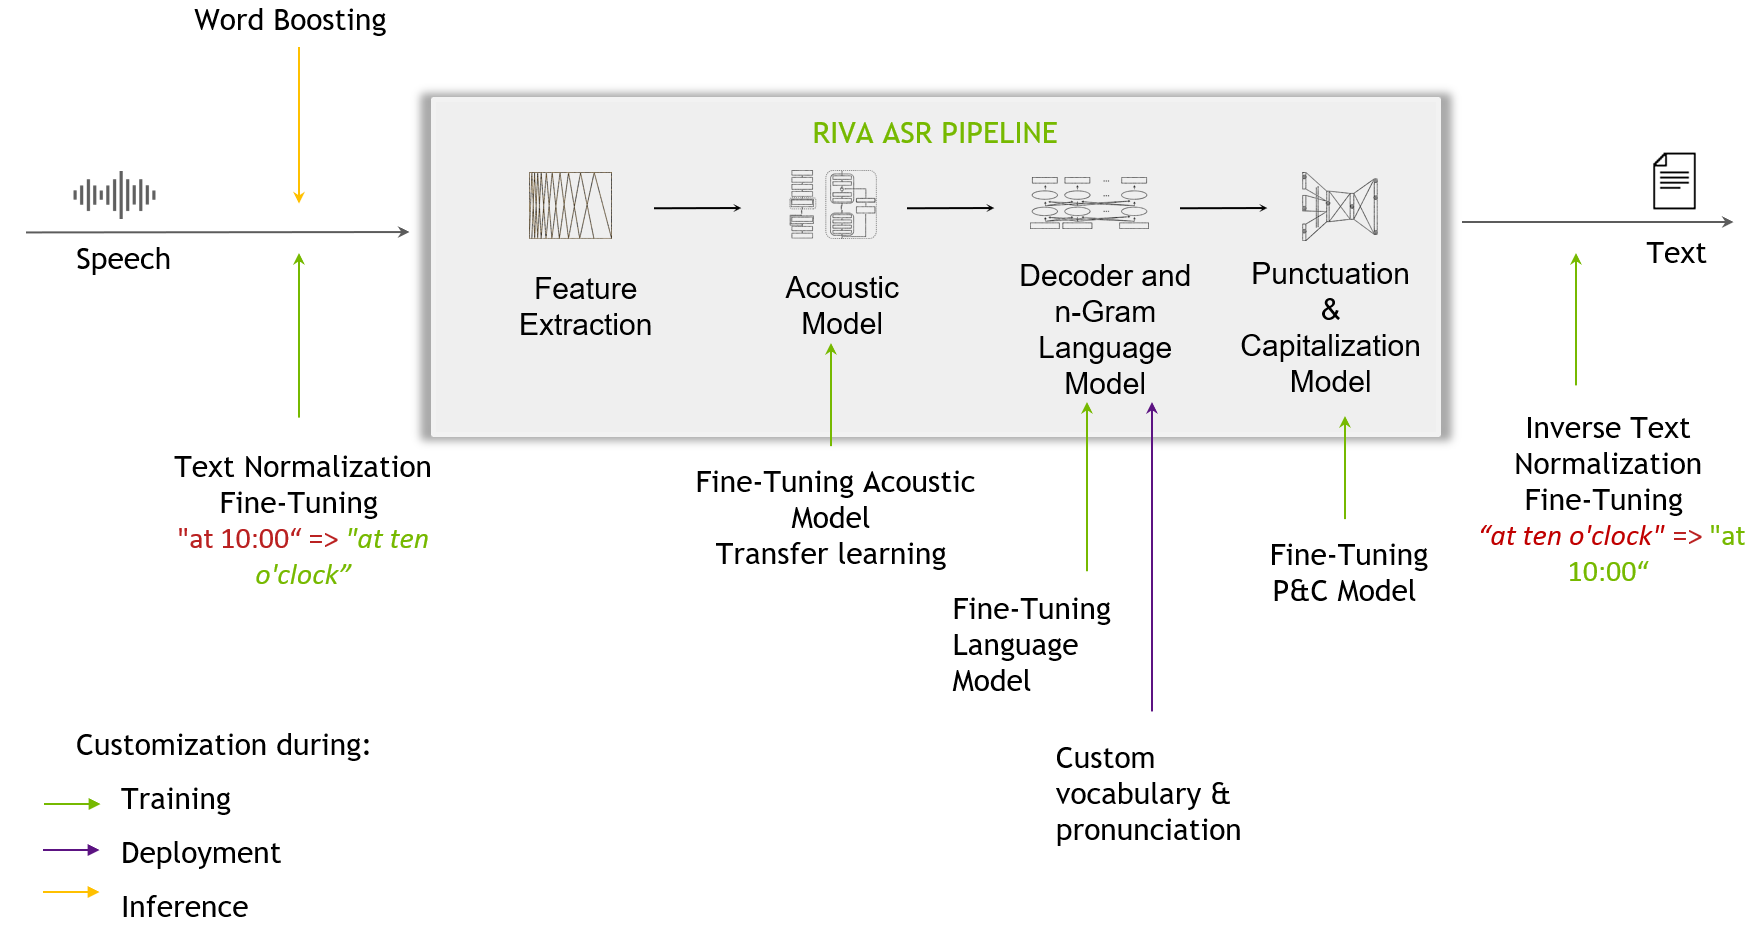

In [6]:
from IPython.display import Image
Image(filename='Riva-customizations.PNG')

To improve the recognition of specific words, the following customizations can be attempted, listed in increasing order of difficulty and efforts:

|              Techniques              |    Difficulty   |                                                  What it does                                                  |                                         When to use                                        |       How to use       |
|:------------------------------------:|:---------------:|:--------------------------------------------------------------------------------------------------------------:|:------------------------------------------------------------------------------------------:|:----------------------:|
| Word boosting                        | Quick and easy  | Temporarily extend the vocabulary while increasing the chance of recognition for a provided list of words.              | When you know that certain words or phrases are important.                                 | [link to notebook TBD] |
| Custom vocabulary                    | Easy            | Permanently extend the default vocabulary to cover novel words of interest.                                             | When the default model vocabulary does not sufficiently cover the domain of interest.      | [Notebook](https://github.com/nvidia-riva/samples/blob/vinhn-custom-lexicon-notebook/notebooks/Riva_ASR_custom_vocabulary_and_lexicon.ipynb) |
| Lexicon mapping                      | Easy            | Explicitly guide the decoder to map one or more pronunciations (sequences of tokens) to a specific word                                          | When you know a word can have one or several pronunciations.                            | [Notebook](https://github.com/nvidia-riva/samples/blob/vinhn-custom-lexicon-notebook/notebooks/Riva_ASR_custom_vocabulary_and_lexicon.ipynb) |
| Retrain language model               | Moderate        | Train a new language model for the application domain to improve the recognition of domain specific terms.     | When domain text data is available.                        | [link to notebook TBD] |
| Fine tune an existing acoustic model | Moderately hard | Fine tune an existing acoustic model using a small amount of domain data to better suit the domain. | When transcribed domain audio data is available (10h-100h), and other easier approaches fall short.   | [link to notebook TBD] |

In the next section, we will give a more detailed discussions of each technique. For a how-to step-by-step guide, consult the notebooks linked in the table.

## 1. Word boosting

Of all the adaptation techniques, word boosting is the easiest and quickest to implement. Word boosting allows you to bias the ASR engine to recognize particular words of interest at request time, by giving them a higher score when decoding the output of the acoustic model.
All  you need to do is to pass a list of words of importance to the model along with a weight as extra context to the API call, as per the below example.

```
# Word Boosting
boosted_lm_words = ["BMW", "Ashgard"]
boosted_lm_score = 20.0
speech_context = rasr.SpeechContext()
speech_context.phrases.extend(boosted_lm_words)
speech_context.boost = boosted_lm_score
config.speech_contexts.append(speech_context)

# Creating StreamingRecognitionConfig instance with config
streaming_config = rasr.StreamingRecognitionConfig(config=config, interim_results=True)
```
Word boosting provides a quick and temporary, on the spot adaptation for the model to cope with new scenarios, such as recognizing proper names and products, new or domain specific terminologies. For OOV words, the word boosting functionality will extend the vocabulary at the same time. 
You will have to explicitly specify the list of boosted words at every request. Other adaptation methods such as custom vocabulary and lexicon mapping provide a more permanent solution, which affects every subsequent request. 

Pay attention to the followings while implementing word boosting:
- Word boosting can improve the chance of recognition of the desired words, but at the same time can increase false positives. As such, start with a small positive weight and gradually increase till you see positive effects. As a general guide, start with a boosted score of 20 and increase up to 100 if needed.
- Word boosting is most suitable as a temporary fix for a new situation. However, if you wish to use it as a permanent adaptation, you can attempt binary search for the boosted weights while monitoring the accuracy metrics on a test set. The accuracy metrics should include both the word error rate (WER) and/or a form of term error rate (TER) focusing on the terms of interest.


## 2. Custom vocabulary

The Flashlight decoder, deployed by default in Riva, is a lexicon-based decoder and only emits words that are present in the provided vocabulary file. That means, domain specific words that are not present in the vocabulary file will have no chance of being generated. 

There are two ways to expand the decoder vocabulary:
- At Riva build time: When building a custom model. Passing the extended vocabulary file to the `--decoding_vocab=<vocabulary_file>` parameter of the `riva-build` command.
Out of the box vocabulary files  for Riva languages can be found on NGC, for example, for English, the vocabulary file named `flashlight_decoder_vocab.txt` can be found at this [link](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/tao/models/speechtotext_en_us_lm/files?version=deployable_v1.1).

- After deployment: For a production Riva system, the lexicon file can be modified, extended and will take effect after a server restart. See the next section. 

It is noted that the greedy decoder (available during the riva-build process under the flag `--decoder_type=greedy`) is not vocabulary based and hence can produce any character sequence.

## 3. Lexicon mapping

When using the Flashlight decoder, the lexicon file provides a mapping between vocabulary dictionary words and its pronunciation, which is sentence piece tokens for many Riva models.

Modifying the lexicon file serves two purposes:
- Extend the vocabulary.
- Provide one or more explicit custom pronunciations for a specific word.

See the [notebook on lexicon mapping]() for a step-by-step procedure and case studies.


## 4. Retrain language model

Introducing a new language model to an existing ASR pipeline is another approach to improve accuracy for niche settings. Riva supports n-gram language models trained and exported from either NVIDIA TAO Toolkit or KenLM. See Riva [documentation](https://docs.nvidia.com/deeplearning/riva/user-guide/docs/asr/asr-customizing.html#training-language-models) for details.

An n-gram language model estimates the probability distribution over groups of n or less consecutive words. By altering or biasing the data on which a language model is trained on, and thus the distribution it is estimating, it can be used to predict different transcriptions as more likely, and thus alter the prediction without changing the acoustic model. 

Note that currently Nemo and TAO only trains LM from scratch, as such, you should ensure a substantial amount of domain text is available for training. In addition, when the text belongs to a narrow, niche domain, there might be an impact to the overall ASR pipeline in recognizing general domain language, as a trade-off. Therefore, you should experiment with mixing domain text with general text for a more balanced representation.

You should limit vocabulary size if using scraped text. Many online sources contain typos or ancillary pronouns and uncommon words. Removing these can improve the language model.



## 5. Fine tune the acoustic model

When other easier approaches have failed to address accuracy issues in challenging situations brought about by significant acoustic factors, such as different accents, noisy environments or audio quality, fine-tuning acoustic models should be attempted.

We recommend fine-tuning ASR models with sufficient data approximately on the order of 100 hours of speech or more, as shown in this research [paper](https://arxiv.org/pdf/2005.04290.pdf).

### Low-resource domain adaptation
In case of smaller datasets, such as ~10 hours, appropriate precautions should be taken to avoid overfitting to the domain and hence sacrificing significant accuracy in the general domains, aka. “catastrophic forgetting”. In transfer learning, continual learning is a sub-problem wherein models that are trained with new domain data should still retain good performance on the original source domain.

If fine-tuning will be done on this small dataset, mix with other larger datasets (“base”).  For English for example, Nemo has a list of [public datasets](https://github.com/NVIDIA/NeMo/blob/main/docs/source/asr/datasets.rst) that can be mixed with.

If using NeMo to fine tune ASR models, consult this Nemo [tutorial](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/tlt-riva/resources/punctuationcapitalization_notebook). 

### Data quality and augmentation

Use lossless audio formats if possible. The use of lossy codecs such as MP3 can reduce quality. As a common practice, use a minimum sampling rate of 16kHz if possible.

Augment training data with noise can improve the model ability to cope with noisy environments. Adding background noise to audio training data can initially decrease accuracy, but increase robustness.


### Train models from scratch
End-to-end training of Automatic Speech Recognition (ASR) models requires large datasets and heavy compute resources. There are more than 5,000 languages around the world, but very few languages have datasets large enough to train high quality ASR models.

For this reason, we only recommend training models from scratch where several thousands of hours of transcribed speech data is available.

# Conclusion

Riva offers a rich set of customization techniques that you can attempt to improve out-of-the-box performance when dealing with novel and challenging situations, not yet covered in the training data.